# Exercises

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pickle
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath("code"))
from utils import download_data
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})


### Exercise 1
---
Use the sklearn `make_blobs()` function, in the same way that we used in the lesson, to generate a *non linearly separable* dataset with 2 features.  
Fit a linear SVM to the dataset many times, varying the slack hyperparameter $C$, and calculate the model performance in classifying the data.  
What is, approximately, a the best value of the $C$ hyperparameter for this dataset?

To test the performance, I am going to use cross validation with `n_splits` = 5. Setting `cluster_std` = .7 makes the two blobs non linearly separable.

In [2]:
np.random.seed(0)

In [3]:
X_nsep,y_nsep = make_blobs(n_samples=100,n_features =2,centers=[[-1,0],[1,0]],cluster_std=.7)

In [4]:
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

#from the graph below, C values larger than 2 do not change the margins anymore.
C_values = np.linspace(0.0001,2,1000)

X, y = X_nsep, y_nsep

accuracies = []
n_splits=5

avg_performance = []
std_performance = []

for i in tqdm(range(len(C_values))):
    C=C_values[i]
    svc_model = svm.SVC(kernel='linear', C=C)
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
    fold_performance = []
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model on the training data
        svc_model.fit(X_train, y_train)
        
        # Evaluate the model on the test data
        fold_performance.append(svc_model.score(X_test, y_test))

    avg_performance.append(np.mean(fold_performance))
    std_performance.append(np.std(fold_performance))

avg_performance = np.asarray(avg_performance)
std_performance = np.asarray(std_performance)

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 160.14it/s]


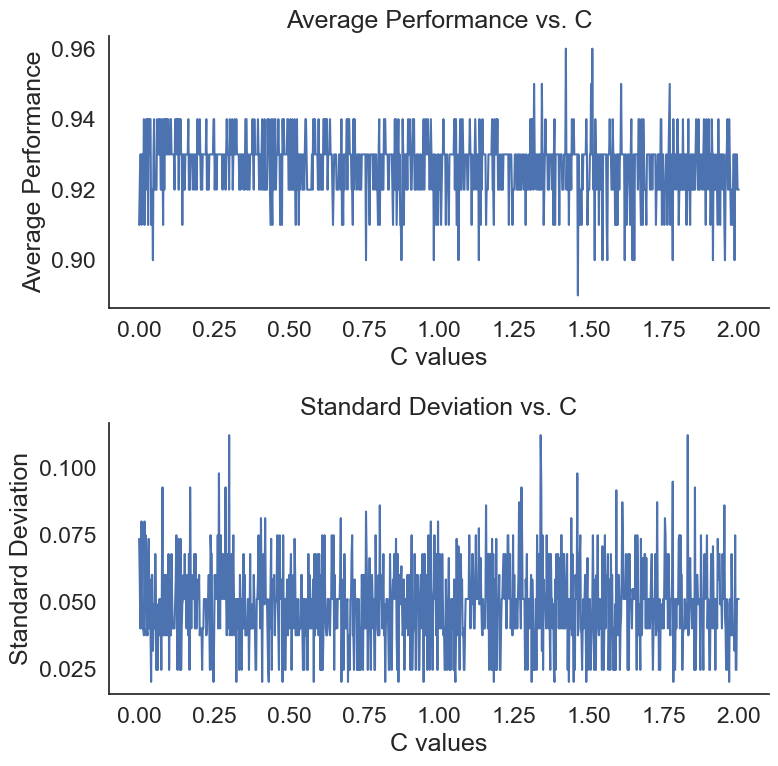

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot average performance
ax1.plot(C_values, avg_performance)
ax1.set_xlabel('C values')
ax1.set_ylabel('Average Performance')
ax1.set_title('Average Performance vs. C')

# Plot standard deviation
ax2.plot(C_values, std_performance)
ax2.set_xlabel('C values')
ax2.set_ylabel('Standard Deviation')
ax2.set_title('Standard Deviation vs. C')

plt.tight_layout()
plt.show()

As you can see, the optimal C is hard to determine since it fluctuates a lot. However, if we apply a gaussian filter to our data we might get some insight:

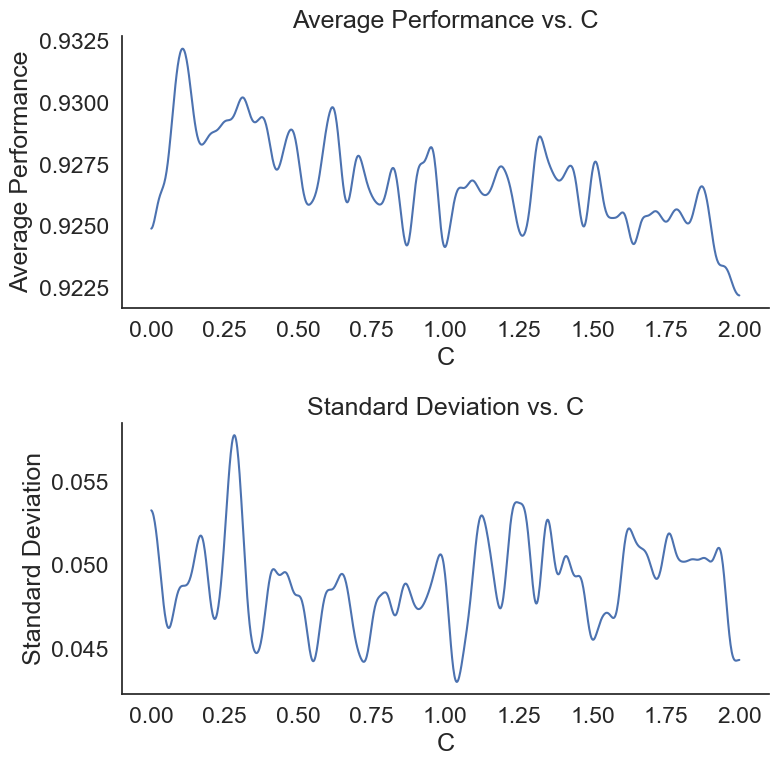

In [6]:
#Use a gaussian filter to smooth the function
from scipy.ndimage import gaussian_filter1d

avg_performance_smooth = gaussian_filter1d(avg_performance,10)
std_performance_smooth = gaussian_filter1d(std_performance,10)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot average performance
ax1.plot(C_values, avg_performance_smooth)
ax1.set_xlabel('C')
ax1.set_ylabel('Average Performance')
ax1.set_title('Average Performance vs. C')

# Plot standard deviation
ax2.plot(C_values, std_performance_smooth)
ax2.set_xlabel('C')
ax2.set_ylabel('Standard Deviation')
ax2.set_title('Standard Deviation vs. C')

plt.tight_layout()
plt.show()

Still, the difference in performance is minimal. However, the average performance decreases after $C \approx 0.15$. Since the std keeps fluctuating I would go with this C as the optimal C. Now let's visualize this:

Text(0, 0.5, 'X2')

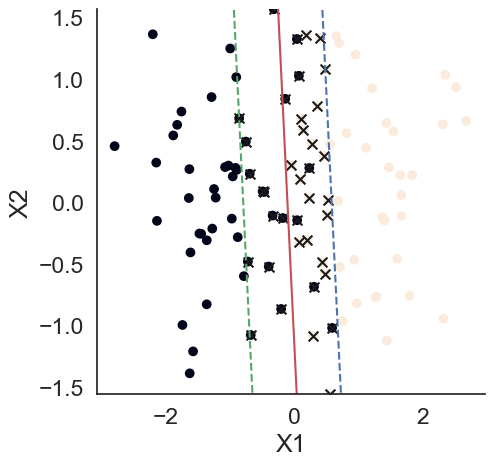

In [14]:
plt.figure(figsize=(5,5))
svc_model = svm.SVC(kernel='linear',C=.15);
svc_model.fit(X, y)
plt.scatter(X[:,0],X[:,1],c=y)
# Constructing a hyperplane using a formula.
w = svc_model.coef_[0]           # w consists of 2 elements
b = svc_model.intercept_[0]      # b consists of 1 element
x_points = np.linspace(-2,2)    # generating x-points from -1 to 1
y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points    N.B. hyperplane: ax+by+c=0 where
                                                                    # a = w[0] , b = w[1] , c = b, x = x1 and y = x2.
                                                                    # Rewrite this equation and get the result.  
# Plotting a red hyperplane
plt.plot(x_points, y_points, c='r');
# Encircle support vectors
plt.scatter(svc_model.support_vectors_[:, 0],
            svc_model.support_vectors_[:, 1], 
            s=50, 
            c='k',
            marker='x');
# Step 2 (unit-vector):
w_hat = svc_model.coef_[0] / (np.sqrt(np.sum(svc_model.coef_[0] ** 2)))
# Step 3 (margin):
margin = 1 / np.sqrt(np.sum(svc_model.coef_[0] ** 2))
# Step 4 (calculate points of the margin lines):
decision_boundary_points = np.array(list(zip(x_points, y_points)))
points_of_line_above = decision_boundary_points + w_hat * margin
points_of_line_below = decision_boundary_points - w_hat * margin
# Plot margin lines
# Blue margin line above
plt.plot(points_of_line_above[:, 0], 
         points_of_line_above[:, 1], 
         'b--')
# Green margin line below
plt.plot(points_of_line_below[:, 0], 
         points_of_line_below[:, 1], 
         'g--')

plt.ylim([min(X[:,1]),max(X[:,1])])

plt.xlabel('X1')
plt.ylabel('X2')

### Exercise 2
---
Repeat exercise 1, but using a non-linear SVM model (the sklearn class `SVC` uses [Radial Basis Functions](https://en.wikipedia.org/wiki/Radial_basis_function) as a default, check its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)). 
To have a fairer assessment of the performance, train the model on a fraction (e.g. 80%) of the data, and test it on the other 20%.
Compare the performance of a linear SVC and a RBF SVC for dataset that are increaslingly non-linearly-separable.


### Exercise 3
---
Use the code below to simulate new data.
Generate data and then decode the stimulus identity, see how the decoding performance change when you change the following:

- The amplitude of the noise in the firing rate
- The amplitude of the stimulus modulation of the firing rate
- The number of neurons

Plot and comment.

## Useful code
---


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [9]:
n_cells = 20; # number of cells to simulate
n_stim_type = 2; # number of different stimuli
sigma_stim = 0.5 # amplitude of stimulus related modulation
average_firing_rate = 5; # average firing rate across the population

# generate baseline rates from exponential distirbution
cell_rate_baseline = np.random.exponential(average_firing_rate,size=n_cells)

# create stimulus average responses, perturbing the population firng rate profile
# we use a multiplicative modulation in opposite directions for the two stimuli
modulation = sigma_stim*np.random.normal(0,1,size=n_cells)
cell_rate_stim = {1: cell_rate_baseline * (1+modulation),2:cell_rate_baseline * (1-modulation)}
# sets negative firng rate to 0
cell_rate_stim[1][cell_rate_stim[1]<0]=0
cell_rate_stim[2][cell_rate_stim[2]<0]=0

In [10]:
# simulate spiking activity

s_rate = 10000 # the sampling rate of our emulated recording system
noise_rate = 1 # we are going to add some spike noise non related to the task
n_stim = 100 # number of stimuli

stim_dur = 2 #stimulus duration (in seconds)
is_interval = 3 # interval between stimuli  (in seconds)

stim_onsets = np.arange(0,n_stim*(stim_dur+is_interval),(stim_dur+is_interval)) # onset time of each stimulus (in seconds)
stim_type = np.asarray([1 for i in range(int(n_stim/2))]+[2 for i in range(int(n_stim/2))]) # identity of each stimulus
np.random.shuffle(stim_type)

time = np.arange(0,(n_stim+1)*(stim_dur+is_interval),1.0/s_rate) # vector of the sampled times.

spike_times = []
for cell in range(n_cells):
    spikes = np.random.poisson(cell_rate_baseline[cell]/s_rate,size=time.shape)
    for i,stimulus in enumerate(stim_type):
        stim_idxs = np.arange(stim_onsets[i]*s_rate,(stim_onsets[i]+stim_dur)*s_rate)
        spikes[stim_idxs] = np.random.poisson(cell_rate_stim[stimulus][cell]/s_rate,size=stim_idxs.shape)

    spike_times.append(time[spikes>0])



In [11]:
# save ouput
out_dict = {'spike_times':spike_times,
            'stim_onsets':stim_onsets,
            'stim_type':stim_type,
            'stim_duration':stim_dur
            }

with open('data/simulated_data1.pickle', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
